<a href="https://colab.research.google.com/github/david-adewoyin/machine_learning_basics/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Forest
**Random Forest** is a tree ensemble where we try to provide an improvement over bagging trees by decorrelates the trees.

Similar to bagging, we build a number of decision trees on boostrapped training samples, but each time a split is considered ,a random sample of **m features** is chosen as candidates to choose from, and a fresh set of m features is taken at each split, typically we choose $m \approx \sqrt{p}$.

The idea being by considering a random subset of features at each split time, we can reduce the correlation of the trees, for example if a feature is a strong predictor in the dataset along with a few others, most if not all of the trees in the bagging ensemble will use the feature in the top split and thereby have a similar look to each other.

Random forests overcome this problem by forcing each split to consider only a subset of the predictors will result in the overall variance being reduced.  


<img src='images/random-forest.svg'>

In [24]:
# Importing our dataset
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from collections import Counter
from scipy import stats

import seaborn as sns

np.random.seed(150)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

## Importing our dataset
We are going to be using the iris dataset included with sklearn

In [29]:
data  = load_iris()
X,y = data['data'],data['target']

print(f"X shape : {X.shape}")

X shape : (150, 4)


X_train shape: (120, 4)
X_test shape:(30, 4)


<AxesSubplot:>

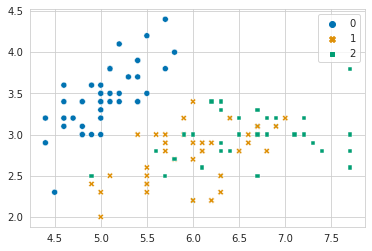

In [32]:
## Splitting the dataset into train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:{X_test.shape}")

sns.scatterplot(x=X_train[:,0], y = X_train[:,1],hue=y_train,style=y_train,palette='colorblind')

## Random Forest

In [33]:
class Node:
    """
    A node is a pointer to other nodes which together makes up a tree
    Leaf node does not have a pointer but contains value which represent the label
    """
    
    def __init__(self,feature=None,left=None, right=None, threshold=None, value=None):
        self.left = left
        self.right = right
        self.threshold = threshold  # threshold to divide element into left or right sub nodes
        self.feature =feature
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [221]:
class RandomForest:
    def __init__(self, min_samples_split = 3, max_depth=10,max_samples=1.0,
                 min_samples_leaf = 1,
                 n_trees=10,num_of_features_to_split=None):
        
            self.min_samples_leaf = min_samples_leaf # amount of samples that must at least  be in each split
            self.min_samples_split = min_samples_split
            self.max_depth = max_depth
            self.n_trees = n_trees
            self.max_samples = max_samples ## size of the boostrap samples
            
            self.num_of_features_to_split = num_of_features_to_split
            self.trees = list(range(n_trees))
            
    def fit(self,X,y):
        m,n_features = X.shape

        if self.num_of_features_to_split == None:
            ## use the square root of the the total number of featues is not set
            self.num_of_features_to_split = np.ceil(np.sqrt(n_features)).astype(np.int64)
        else:
            # makes sure the num of features is not greather than the total number of features
            self.num_of_features_to_split = min(self.num_of_features_to_split,n_features)
            
        # to help work with pandas
        if isinstance(X, np.ndarray):
            self._build_tree_ensemble(X,y)
            return 
        self._build_tree_ensemble(X.values,y.values)
    
    def _build_tree_ensemble(self,X,y):
        for i in range(self.n_trees):
            bootstrap_X, bootstrap_y = self._bootstrap_sample(X,y)
            self.trees[i] = self._build_tree(bootstrap_X,bootstrap_y)  
            
    def _bootstrap_sample(self,X,y):
        # bootstrap samples from dataset
        sample = list()
        m_rows,_ = X.shape
        n_samples = round(m_rows * self.max_samples)
        indices = np.random.default_rng().choice(m_rows,n_samples,replace=True) # boostrap sample from dataset
        return X[indices], y[indices]
        
        
    def _build_tree(self, X, y, depth = 0):
        n_samples,n_features = X.shape
       
        n_labels = len(np.unique(y)) # check if the current node contains element of only 1 class
        
        ## Stopping Criteria to determine when to stop builing our tree
        if (depth >= self.max_depth 
            or n_samples <= self.min_samples_split
           or n_labels <= 1 ):
            #find value for the leaf node
            leaf_value = self._voted_label(y)
            return Node(value = leaf_value)
        
        # randomly choose a subset of the features to split on
        feat_idx = np.random.default_rng(110).choice(n_features,size=self.num_of_features_to_split,replace = False)
        feature,thresh = self._find_best_split(X,y,feat_idx)

        
        X_column = X[:,feature]
        left_in,right_in = self._split_dataset(X_column, thresh)
        
        # check if split results in at least minimum samples in each nodes
        if len(left_in) <=self.min_samples_leaf or len(right_in) <=  self.min_samples_leaf:
            leaf_value = self._voted_label(y)
            return Node(value = leaf_value)
      
        leftX_node, rightX_node = X[left_in,:], X[right_in,:]
        lefty_node ,righty_node = y[left_in], y[right_in]
                      
        # recursively build sub trees
        left =  self._build_tree(leftX_node, lefty_node, depth + 1)
        right = self._build_tree(rightX_node, righty_node, depth +1 )
        
        return Node(feature,threshold=thresh ,left= left,right = right)  
        
    def _find_best_split(self,X,y,feat_indices):
        # find the feature and threshold that result in the best split
        best_gain = -1
        best_feature = 0
        best_threshold = 0
        for feat in feat_indices:
    
            X_column = X[:,feat]
            threshold = np.unique(X_column)
           
            for thresh in threshold:
                gain = self._information_gain(X_column,y,split_thresh = thresh)

                if gain > best_gain:
                    best_gain = gain
                    best_threshold = thresh
                    best_feature = feat
   
        return best_feature ,best_threshold     
    
    def _split_dataset(self,X_column,split_thresh):
        ## split our dataset using element of a particular feature and given threshold
        left_indices = np.argwhere(X_column <= split_thresh).flatten()
        right_indices = np.argwhere(X_column > split_thresh).flatten()
        return left_indices,right_indices
    
    def _entropy(self,y):
        if len(y) == 0: # Check if the list is empty
            return 0 
        hist = np.bincount(y)
        px = hist / len(y)
        entropy = - np.sum([p * np.log2(p) for p in px if p>0])
        return entropy
    
    def _information_gain(self,X_column,y,split_thresh):
        left_indices,right_indices =  self._split_dataset(X_column,split_thresh)  
        if len(left_indices) == 0 or len(right_indices) ==0:
            return 0

        node_left,node_right = y[left_indices],y[right_indices]
        frac_left = len(node_left)/len(y)
        frac_right = 1 - frac_left
        
        root_entropy =self._entropy(y)
        child_entropy = frac_left * self._entropy(node_left) + frac_right * self._entropy(node_right)
        
        information_gain = root_entropy - child_entropy
        return information_gain 
    
    def _voted_label(self, y):
        # returns the model with the highest label
        counter = Counter(y)

        return counter.most_common(1)[0][0]
    
    def predict(self,X):
        if not isinstance(X,np.ndarray):
            X = X.values
       
        predictions_across = np.zeros((self.n_trees,X.shape[0]),dtype=np.int64)
        
        # store predictions across trees in array
        for i in range(self.n_trees):
            v = np.array([self._tranverse_tree(x,self.trees[i]) for x in X ])
            predictions_across[i,:] = v
       
        # find the mode of each rows across the entire trees
        return stats.mode(predictions_across)[0].flatten()
    
    def _tranverse_tree(self,x,node):
        """
        We tranverse our tree from the root node until we reach a leaf node
        """
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._tranverse_tree(x,node.left)
        return self._tranverse_tree(x,node.right)

## Training our model 

In [232]:
## Instantializing our model
tree =  RandomForest(n_trees=13,max_depth=100,min_samples_split = 3,min_samples_leaf=3)
tree.fit(X_train,y_train)

In [233]:
y_pred = tree.predict(X_train)

acc_train = accuracy_score(y_train,y_pred)
print(f"accuracy on the training set: {acc_train :.3f}")

accuracy on the training set: 0.950


## Testing our model

In [234]:
## calling predict on the test set
y_pred = tree.predict(X_test)

## calculating the accuracy of our model 
acc_test = accuracy_score(y_test,y_pred)
print(f"accuracy on the testing set: {acc_test:.3f}")

accuracy on the testing set: 1.000


[learn more about random forest from here](http://www2.stat.duke.edu/~rcs46/lectures_2017/08-trees/08-tree-advanced.pdf)